**Some notebook stuff**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Libraries**

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
import time
import methods as mt
import datetime
import pandas as pd

**Import molecule data**

In [3]:
# Create dictionaries of nodes/edges for all molecules
roots = mt.importMolecule('gxl')
nodesDict, edgesDict, edgesCountDict = mt.moleculeToList(roots)

## KNN Algorithm:
1. compare every molecule (from the valid set) with every other molecule (from the train set)
 - calculate for each the GED (graph edit distance between the two molecules) using bipartite graph matching
 - build cost matrix using Dirac cost function (see lecture 9 slide 36)
 - use Hungarian algorithm to find optimal assignment (using an existing framework!)
2. for ever molecule (from the valid set) find the K closest molecules (in the test set)
 - the K molecules with the shortest GED (since we only have two classes (active, inactive): use odd K!)
 - using valid.txt check if the KNN (the K closest neighbour molecules) are active or inactive
 - assign train molecule to the closer class (and check if assignment was correct using valid.txt (for accuracy measurement))
 - repeat for neighbourhood size k from 1 to train set size

**Import validation and training data**

In [4]:
import pandas as pd
def read_file(file):
    df = pd.read_csv(file, sep=' ', header=None)
    lst = df.values.tolist()
    d = dict()
    for elt in lst:
        d[int(elt[0])] = {'class': elt[1], 'value': 1 if elt[1] == 'a' else 0}
    #lst: list of molecules [number, a/i]
    #  d: dict of molecules. key is number, value is {class: i/a, value: 1,0}
    return lst, d

validData, validDict = read_file('valid.txt')
trainData, trainDict = read_file('train.txt')

**Compute distance matrix**

In [13]:
# load or compute distance matrix for all molecules (takes ~25sec to compute)

def computeDistance(molecule1, molecule2, cn, ce):
    node1 = nodesDict[molecule1]
    node2 = nodesDict[molecule2]
    edges1 = edgesCountDict[molecule1]
    edges2 = edgesCountDict[molecule2]
    return mt.BP_fast(node1, node2, edges1, edges2, Cn=cn, Ce=ce)

def distMat(cn,ce):
    print("computing distanceMatrix...")
    a = np.array([i[0] for i in validData])
    b = np.array([i[0] for i in trainData])
    fv = np.vectorize(computeDistance)
    start_time = time.time()
    distanceMatrix = fv(a[:, np.newaxis], b, cn, ce)
    print('Distance matrix found ({})'.format(datetime.timedelta(seconds=int(time.time() - start_time))))
    #np.save("distanceMatrix.npy", distanceMatrix)
    return distanceMatrix

distanceMatrix = distMat(1,1)
pd.DataFrame(distanceMatrix)

computing distanceMatrix...
Distance matrix found (0:00:16)


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,19.0,12.0,14.0,19.0,26.0,33.0,25.0,25.0,29.0,26.0,...,9.0,13.0,17.0,11.0,11.0,13.0,11.0,17.0,9.0,9.0
1,28.0,13.0,3.0,12.0,19.0,24.0,18.0,14.0,20.0,15.0,...,16.0,16.0,24.0,16.0,16.0,16.0,18.0,26.0,14.0,18.0
2,29.0,14.0,4.0,9.0,16.0,21.0,17.0,9.0,19.0,12.0,...,19.0,17.0,25.0,17.0,17.0,17.0,23.0,29.0,15.0,23.0
3,31.0,12.0,20.0,11.0,8.0,19.0,15.0,15.0,19.0,18.0,...,25.0,27.0,27.0,23.0,23.0,27.0,31.0,35.0,23.0,33.0
4,37.0,18.0,16.0,7.0,12.0,13.0,3.0,15.0,13.0,22.0,...,23.0,25.0,33.0,21.0,21.0,27.0,29.0,35.0,19.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,20.0,19.0,21.0,24.0,33.0,34.0,30.0,32.0,30.0,31.0,...,6.0,14.0,18.0,12.0,14.0,14.0,6.0,20.0,12.0,6.0
246,22.0,21.0,19.0,24.0,31.0,34.0,30.0,30.0,30.0,27.0,...,10.0,12.0,18.0,10.0,12.0,12.0,6.0,20.0,12.0,6.0
247,16.0,17.0,17.0,22.0,29.0,34.0,26.0,26.0,30.0,29.0,...,8.0,10.0,14.0,10.0,8.0,12.0,8.0,18.0,6.0,6.0
248,12.0,19.0,19.0,22.0,27.0,38.0,30.0,26.0,36.0,29.0,...,12.0,6.0,8.0,10.0,8.0,6.0,12.0,14.0,8.0,8.0


In [9]:
accuracy = 0
k = 1
accs = []
k_vals = []
validLength = len(validData)
while k <= len(validData):
    for r in range(len(validData)):
        row = np.squeeze(np.asarray(distanceMatrix[r]))
        idx = np.argpartition(row, k)
        summation = 0
        for i in range(k):
            summation += trainDict[trainData[idx[i]][0]]['value']
    
        if summation > k/2:
        #     active
            if validDict[validData[r][0]]['class'] == 'a' :
                accuracy += 1
        else:
        #     inactive
            if validDict[validData[r][0]]['class'] == 'i' :
                accuracy += 1
    accs.append(accuracy/validLength)
    k_vals.append(k)
    k += 2
    accuracy = 0

#### Results
Plotting shows the best neigbhourhood size k is with k=3  
With k's larger than 99 the accuracy stays at 0.8.

(<Figure size 648x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c8d3058>)

Text(0.5, 0, 'k')

Text(0, 0.5, 'accuracy')

Text(0.5, 1.0, 'Accuracy over increasing neighbourhood sizes K')

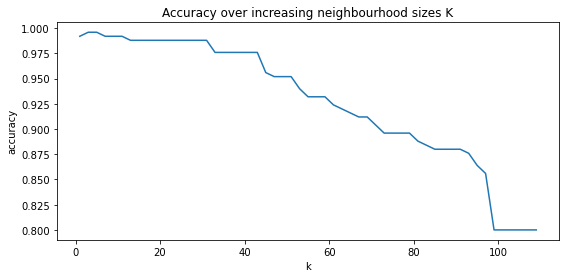

In [10]:
import matplotlib as plt
import matplotlib.pyplot as plt
plt.subplots(figsize=(9,4))
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(k_vals[:55], accs[:55])
plt.title("Accuracy over increasing neighbourhood sizes K")
plt.show()
#plt.savefig("rmse_all.png", dpi=300)

In [11]:
print("Worst K:", k_vals[np.argmin(accs)], "with accuracy:", min(accs))

Worst K: 99 with accuracy: 0.8


In [12]:
print("Beest K:", k_vals[np.argmax(accs)], "with accuracy:", max(accs))

Beest K: 3 with accuracy: 0.996
